In [1]:
import torch
from torch import nn
import torchvision
from torchvision import utils, datasets, transforms
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
data_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = Path("data")
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_ds = datasets.CIFAR10(root=DATA_DIR,
                            train=True,
                            transform=data_trans,
                            download=True)
test_ds = datasets.CIFAR10(root=DATA_DIR,
                           train=False, 
                           transform=data_trans,
                           download=True)
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class_names = train_ds.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


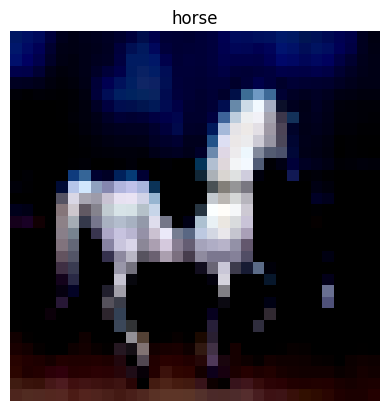

In [5]:
import random

sample = random.choice(train_ds)
img, lbl = sample[0], sample[1]
plt.imshow(img.permute(1, 2, 0));
plt.title(class_names[lbl]);
plt.axis(False);

In [6]:
def accuracy_score(y, y_pred):
    return torch.sum(y == y_pred) / len(y_pred) * 100

In [14]:
class CIFAR_model(nn.Module):
    def __init__(self, in_channels, output):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64)
            nn.Dropout()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128)
        )
        
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.Linear(1024, output)
        )
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        return self.classifier(out)

    
model = CIFAR_model(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

In [15]:
model(next(iter(train_dataloader))[0][0].unsqueeze(0).to(DEVICE))

tensor([[-0.1886, -0.7691, -0.2624,  0.1313, -0.6485,  0.0771, -0.3121, -0.2820,
         -0.1614, -0.6020]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 13, 0.1)

train_acc_res = []

test_acc_res = []

In [17]:
from tqdm import tqdm

EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    train_acc, test_acc = 0, 0
    for X, y in train_dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    for X, y in test_dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        model.eval()
        with torch.inference_mode():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        test_acc += acc
    scheduler.step()
    print(f"EPOCH: {epoch + 1}")
    print(f"train: acc - {train_acc / len(train_dataloader)}%\n")
    print(f"test: acc - {test_acc / len(test_dataloader)}%")
    train_acc_res.append(train_acc / len(train_dataloader))
    test_acc_res.append(test_acc / len(test_dataloader))

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:19<09:18, 19.27s/it]

EPOCH: 0
train: acc - 50.333892822265625%

test: acc - 62.92931365966797%


  7%|▋         | 2/30 [00:37<08:41, 18.61s/it]

EPOCH: 1
train: acc - 66.76463317871094%

test: acc - 71.79512786865234%


 10%|█         | 3/30 [01:00<09:18, 20.67s/it]

EPOCH: 2
train: acc - 72.14891052246094%

test: acc - 74.41094207763672%


 13%|█▎        | 4/30 [01:27<09:57, 22.99s/it]

EPOCH: 3
train: acc - 75.43585968017578%

test: acc - 76.93689727783203%


 17%|█▋        | 5/30 [01:49<09:29, 22.78s/it]

EPOCH: 4
train: acc - 77.78511047363281%

test: acc - 78.05510711669922%


 20%|██        | 6/30 [02:13<09:18, 23.26s/it]

EPOCH: 5
train: acc - 79.26463317871094%

test: acc - 78.43450164794922%


 23%|██▎       | 7/30 [02:37<08:56, 23.33s/it]

EPOCH: 6
train: acc - 81.03607177734375%

test: acc - 80.52116394042969%


 27%|██▋       | 8/30 [03:01<08:42, 23.73s/it]

EPOCH: 7
train: acc - 82.41162872314453%

test: acc - 80.84065246582031%


 30%|███       | 9/30 [03:27<08:29, 24.28s/it]

EPOCH: 8
train: acc - 83.48128509521484%

test: acc - 81.73921203613281%


 33%|███▎      | 10/30 [03:50<07:59, 23.97s/it]

EPOCH: 9
train: acc - 84.56893920898438%

test: acc - 81.86901092529297%


 37%|███▋      | 11/30 [04:16<07:48, 24.68s/it]

EPOCH: 10
train: acc - 85.33269500732422%

test: acc - 82.55790710449219%


 40%|████      | 12/30 [04:43<07:35, 25.30s/it]

EPOCH: 11
train: acc - 85.91250610351562%

test: acc - 82.66773223876953%


 43%|████▎     | 13/30 [05:07<07:05, 25.05s/it]

EPOCH: 12
train: acc - 86.71025085449219%

test: acc - 82.1585464477539%


 47%|████▋     | 14/30 [05:34<06:47, 25.46s/it]

EPOCH: 13
train: acc - 90.66698455810547%

test: acc - 84.9041519165039%


 50%|█████     | 15/30 [05:57<06:11, 24.77s/it]

EPOCH: 14
train: acc - 91.73664093017578%

test: acc - 84.83426666259766%


 53%|█████▎    | 16/30 [06:22<05:45, 24.68s/it]

EPOCH: 15
train: acc - 92.15650939941406%

test: acc - 84.8941650390625%


 57%|█████▋    | 17/30 [06:48<05:26, 25.12s/it]

EPOCH: 16
train: acc - 92.48440551757812%

test: acc - 84.94408416748047%


 60%|██████    | 18/30 [07:11<04:53, 24.45s/it]

EPOCH: 17
train: acc - 92.70033264160156%

test: acc - 84.85423278808594%


 63%|██████▎   | 19/30 [07:37<04:35, 25.05s/it]

EPOCH: 18
train: acc - 92.9802474975586%

test: acc - 84.66453552246094%


 67%|██████▋   | 20/30 [08:01<04:07, 24.71s/it]

EPOCH: 19
train: acc - 93.31414031982422%

test: acc - 84.84424591064453%


 67%|██████▋   | 20/30 [08:05<04:02, 24.27s/it]


KeyboardInterrupt: 

train: 93.27 test: 84.85 - record (30 epochs)


In [73]:
train_acc_res_1 = [i.cpu() for i in train_acc_res]
test_acc_res_1 = [i.cpu() for i in test_acc_res]

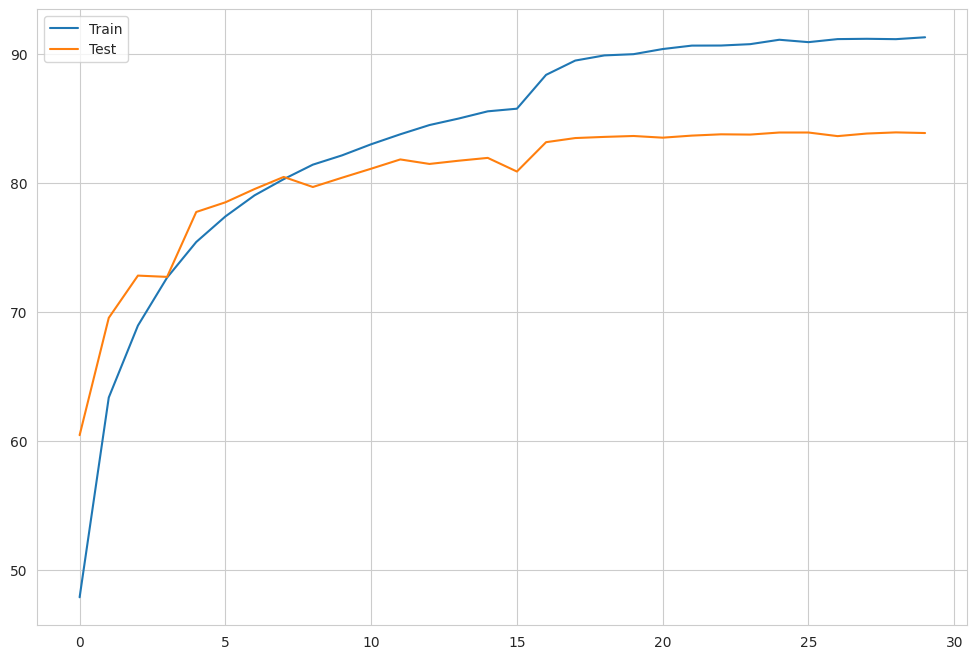

In [86]:
import seaborn
seaborn.set_style("whitegrid")
plt.figure(figsize=(12, 8))
plt.plot(train_acc_res_1, label="Train")
plt.plot(test_acc_res_1, label="Test")
plt.legend()
plt.show()

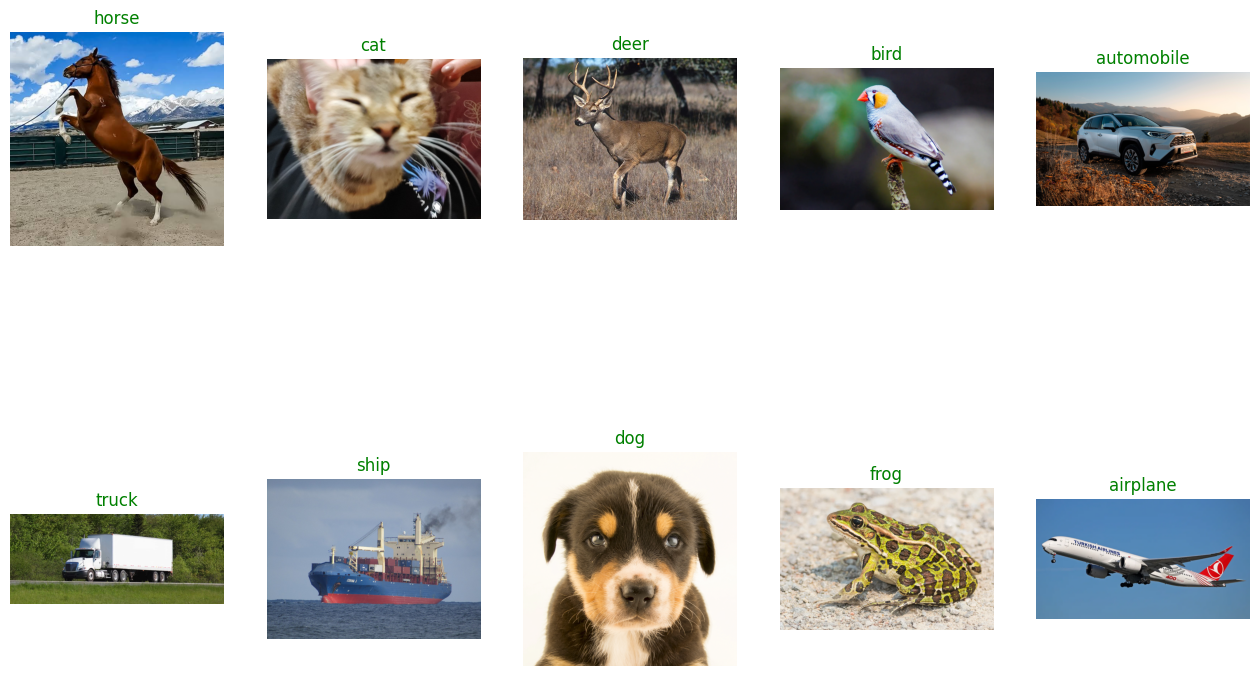

In [85]:
from PIL import Image

fig, ax = plt.subplots(2, 5, figsize=(16, 10))
ax = ax.ravel()
PHOTOS_PATH = Path('my_own_photos')
for ind, name in enumerate(list(os.walk("my_own_photos"))[0][2]):
    photo_path = PHOTOS_PATH / name
    img_orig = Image.open(photo_path)
    img = transforms.Resize((32, 32))(data_trans(img_orig)).to(DEVICE)
    ax[ind].imshow(transforms.ToTensor()(img_orig).permute(1, 2, 0))
    preds = torch.sigmoid(model(img.unsqueeze(0)))
    if class_names[preds.argmax(1)] == name.split('.')[0]:
        ax[ind].set_title(class_names[preds.argmax(1)], c='green')
    else:
        ax[ind].set_title(class_names[preds.argmax(1)], c='red')
        # вывод вероятностей для фотографии 
        probs = {class_names[i]: preds[0][i].item() for i in range(len(class_names))}
        print(f"Probs for {name.split('.')[0]}: {sorted(probs.items(), key=lambda x: x[1])[::-1]}")
    ax[ind].axis(False)
plt.show()